# VisionEval — Preliminary Results Analysis

Evaluating how much Cambrian-1 (8B) relies on image inputs vs language priors.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pathlib import Path

plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

DATA_ROOT = Path('../VisionEvalsResults')
RAW_DIR = DATA_ROOT / 'visioneval_results/results/raw'
OPT_DIR = DATA_ROOT / 'optimization/visioneval_noise_results/optimization'

# Load all benchmark results into a single DataFrame
all_rows = []
for jsonl_path in sorted(RAW_DIR.glob('*.jsonl')):
    with open(jsonl_path) as f:
        for line in f:
            if line.strip():
                all_rows.append(json.loads(line))

df = pd.DataFrame(all_rows)
print(f'Loaded {len(df)} results across {df["benchmark"].nunique()} benchmarks, {df["condition"].nunique()} conditions')
df.groupby(['benchmark', 'condition']).size().unstack(fill_value=0)

Loaded 78485 results across 5 benchmarks, 4 conditions


condition  gaussian_noise  no_image  normal  wrong_image
benchmark                                               
gqa                     0         0    1569            0
mmbench              4329      4329    4329         4329
mmmu                  900       900     900          900
pope                 9000      9000    9000         9000
textvqa              5000      5000    5000         5000

## 1. Accuracy by Benchmark and Condition

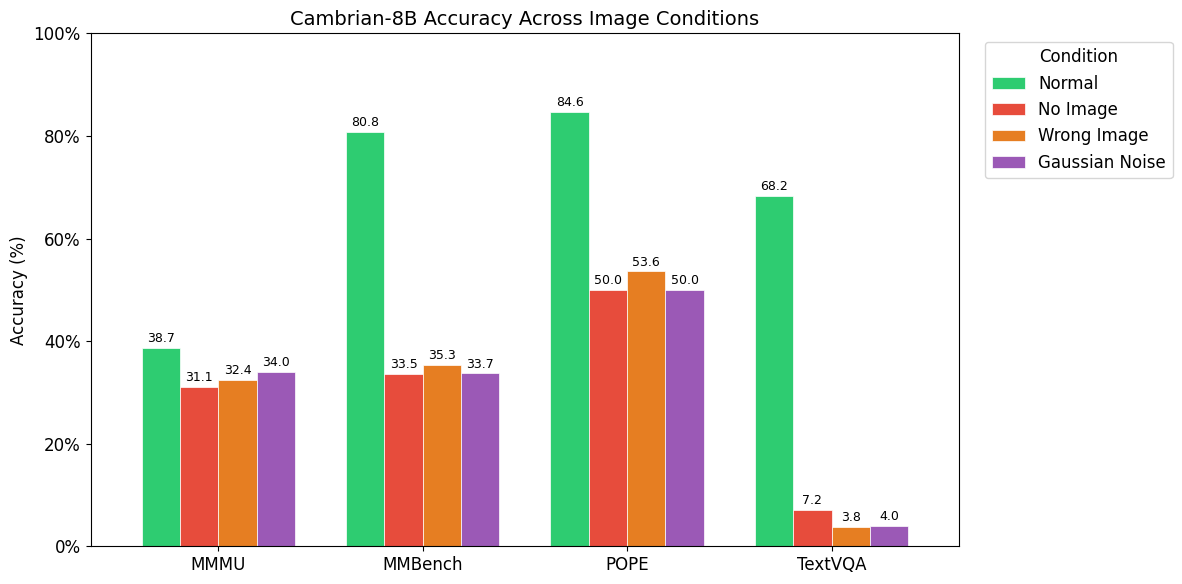


Accuracy Table:
         Normal  No Image  Wrong Image  Gaussian Noise
MMMU       38.7      31.1         32.4            34.0
MMBench    80.8      33.5         35.3            33.7
POPE       84.6      50.0         53.6            50.0
TextVQA    68.2       7.2          3.8             4.0


In [2]:
# Compute accuracy per (benchmark, condition)
acc = df.groupby(['benchmark', 'condition'])['correct'].mean() * 100
acc_df = acc.unstack('condition')

# Reorder
condition_order = ['normal', 'no_image', 'wrong_image', 'gaussian_noise']
condition_labels = ['Normal', 'No Image', 'Wrong Image', 'Gaussian Noise']
benchmark_order = ['mmmu', 'mmbench', 'pope', 'textvqa']
benchmark_labels = ['MMMU', 'MMBench', 'POPE', 'TextVQA']

# Filter to available data
avail_conditions = [c for c in condition_order if c in acc_df.columns]
avail_benchmarks = [b for b in benchmark_order if b in acc_df.index]
acc_plot = acc_df.loc[avail_benchmarks, avail_conditions]

# Map labels
b_label_map = dict(zip(benchmark_order, benchmark_labels))
c_label_map = dict(zip(condition_order, condition_labels))
acc_plot.index = [b_label_map.get(b, b) for b in acc_plot.index]
acc_plot.columns = [c_label_map.get(c, c) for c in acc_plot.columns]

# Plot
colors = ['#2ecc71', '#e74c3c', '#e67e22', '#9b59b6']
ax = acc_plot.plot(kind='bar', color=colors[:len(avail_conditions)], width=0.75, edgecolor='white', linewidth=0.5)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Cambrian-8B Accuracy Across Image Conditions')
ax.set_xlabel('')
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(title='Condition', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', fontsize=9, padding=2)

plt.tight_layout()
plt.savefig('results/plots/fig1_accuracy_by_condition.png', dpi=150, bbox_inches='tight')
plt.show()

# Print table
print('\nAccuracy Table:')
print(acc_plot.round(1).to_string())

## 2. Accuracy Drop from Normal Baseline

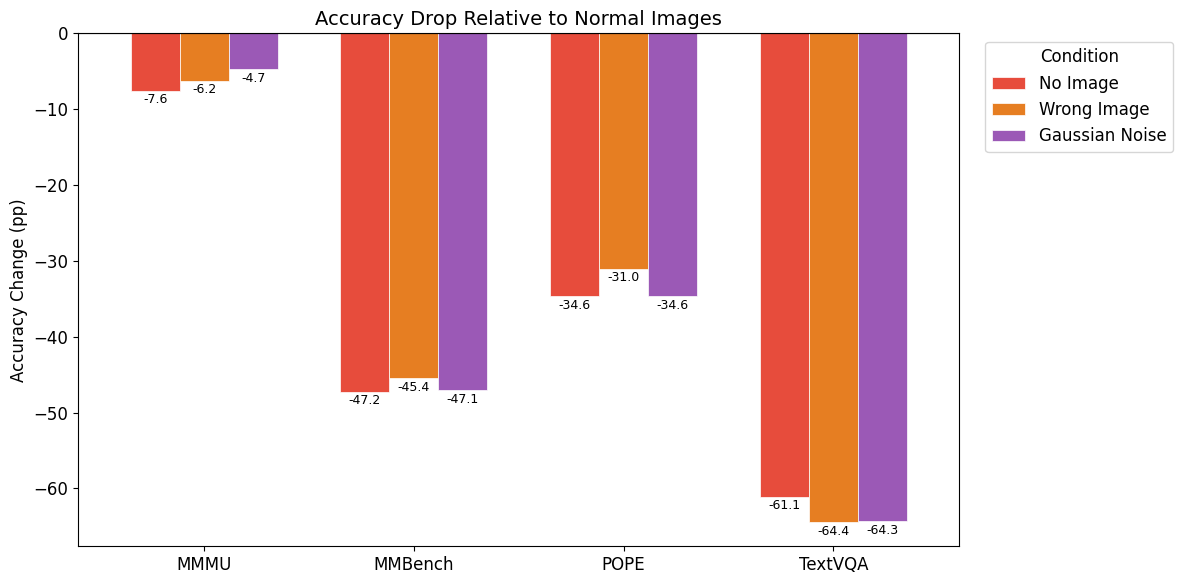

Relative accuracy drop (% of normal accuracy lost):
         No Image  Wrong Image  Gaussian Noise
MMMU        -19.5        -16.1           -12.1
MMBench     -58.5        -56.2           -58.3
POPE        -40.9        -36.7           -40.9
TextVQA     -89.5        -94.4           -94.2


In [3]:
# Compute accuracy drop relative to normal condition
drop_df = acc_plot.copy()
for col in drop_df.columns:
    if col != 'Normal':
        drop_df[col] = acc_plot[col] - acc_plot['Normal']
drop_df = drop_df.drop(columns='Normal')

ax = drop_df.plot(kind='bar', color=colors[1:len(avail_conditions)], width=0.7, edgecolor='white', linewidth=0.5)
ax.set_ylabel('Accuracy Change (pp)')
ax.set_title('Accuracy Drop Relative to Normal Images')
ax.set_xlabel('')
ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-')
ax.legend(title='Condition', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)

for container in ax.containers:
    ax.bar_label(container, fmt='%+.1f', fontsize=9, padding=2)

plt.tight_layout()
plt.savefig('results/plots/fig2_accuracy_drop.png', dpi=150, bbox_inches='tight')
plt.show()

# Relative drop (percentage of normal accuracy lost)
rel_drop = drop_df.copy()
for col in rel_drop.columns:
    rel_drop[col] = (drop_df[col] / acc_plot['Normal']) * 100

print('Relative accuracy drop (% of normal accuracy lost):')
print(rel_drop.round(1).to_string())

## 3. Image Reliance Score

How much does each benchmark actually need the image? Measured as `(normal_acc - no_image_acc) / normal_acc`.

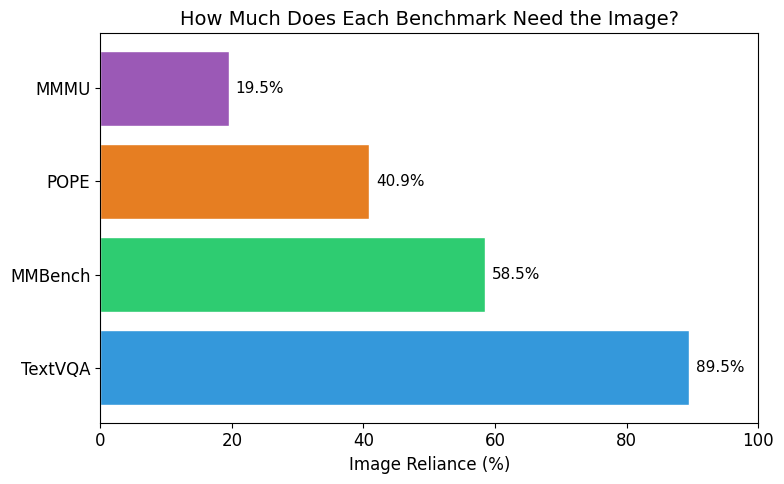

Image reliance = (normal - no_image) / normal x 100
TextVQA    89.5
MMBench    58.5
POPE       40.9
MMMU       19.5


In [4]:
reliance = {}
for bench in avail_benchmarks:
    b_label = b_label_map.get(bench, bench)
    normal_acc = acc.get((bench, 'normal'), 0)
    no_img_acc = acc.get((bench, 'no_image'), 0)
    if normal_acc > 0:
        reliance[b_label] = (normal_acc - no_img_acc) / normal_acc * 100

reliance_s = pd.Series(reliance).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(reliance_s.index, reliance_s.values, color=['#3498db', '#2ecc71', '#e67e22', '#9b59b6'], edgecolor='white')
ax.set_xlabel('Image Reliance (%)')
ax.set_title('How Much Does Each Benchmark Need the Image?')
ax.set_xlim(0, 100)
for bar, val in zip(bars, reliance_s.values):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center', fontsize=11)
plt.tight_layout()
plt.savefig('results/plots/fig3_image_reliance.png', dpi=150, bbox_inches='tight')
plt.show()

print('Image reliance = (normal - no_image) / normal x 100')
print(reliance_s.round(1).to_string())

## 4. Confidence Analysis — How Sure Is the Model?

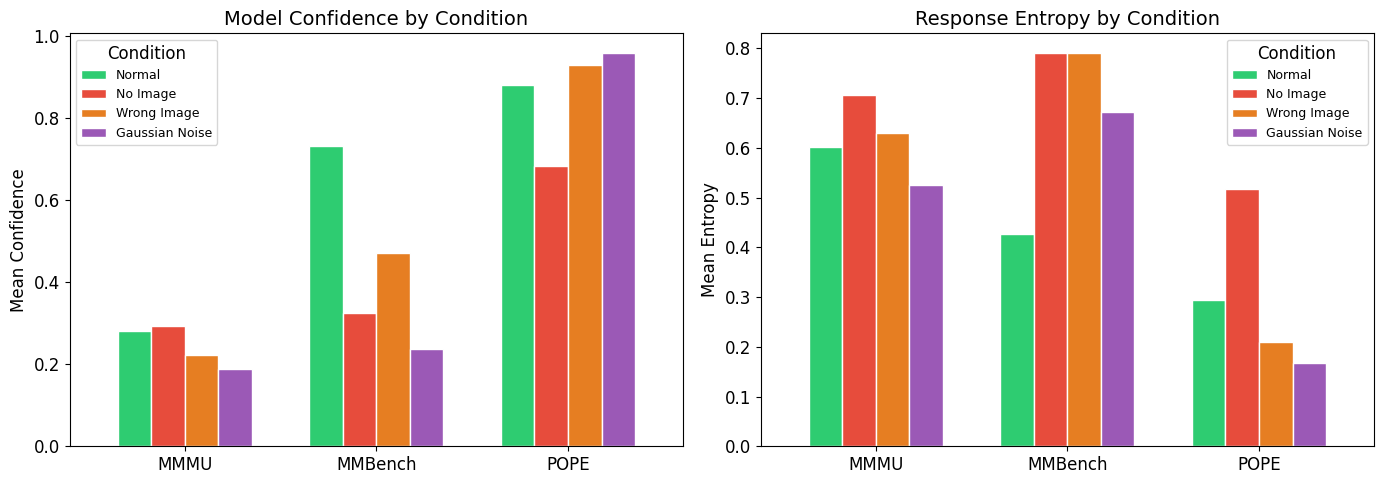

In [5]:
# Filter to rows that have confidence data
conf_df = df[df['confidence'].notna()].copy()

if len(conf_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Average confidence by condition
    conf_by_cond = conf_df.groupby(['benchmark', 'condition'])['confidence'].mean().unstack('condition')
    avail_c = [c for c in condition_order if c in conf_by_cond.columns]
    avail_b = [b for b in benchmark_order if b in conf_by_cond.index]
    conf_plot = conf_by_cond.loc[avail_b, avail_c]
    conf_plot.index = [b_label_map.get(b, b) for b in conf_plot.index]
    conf_plot.columns = [c_label_map.get(c, c) for c in conf_plot.columns]
    
    conf_plot.plot(kind='bar', ax=axes[0], color=colors[:len(avail_c)], width=0.7, edgecolor='white')
    axes[0].set_ylabel('Mean Confidence')
    axes[0].set_title('Model Confidence by Condition')
    axes[0].set_xlabel('')
    axes[0].legend(title='Condition', fontsize=9)
    axes[0].tick_params(axis='x', rotation=0)
    
    # Entropy by condition
    ent_df = df[df['entropy'].notna()].copy()
    ent_by_cond = ent_df.groupby(['benchmark', 'condition'])['entropy'].mean().unstack('condition')
    avail_c2 = [c for c in condition_order if c in ent_by_cond.columns]
    avail_b2 = [b for b in benchmark_order if b in ent_by_cond.index]
    ent_plot = ent_by_cond.loc[avail_b2, avail_c2]
    ent_plot.index = [b_label_map.get(b, b) for b in ent_plot.index]
    ent_plot.columns = [c_label_map.get(c, c) for c in ent_plot.columns]
    
    ent_plot.plot(kind='bar', ax=axes[1], color=colors[:len(avail_c2)], width=0.7, edgecolor='white')
    axes[1].set_ylabel('Mean Entropy')
    axes[1].set_title('Response Entropy by Condition')
    axes[1].set_xlabel('')
    axes[1].legend(title='Condition', fontsize=9)
    axes[1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.savefig('results/plots/fig4_confidence_entropy.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No confidence data available')

## 5. Ground Truth Probability — Does the Model Know the Right Answer?

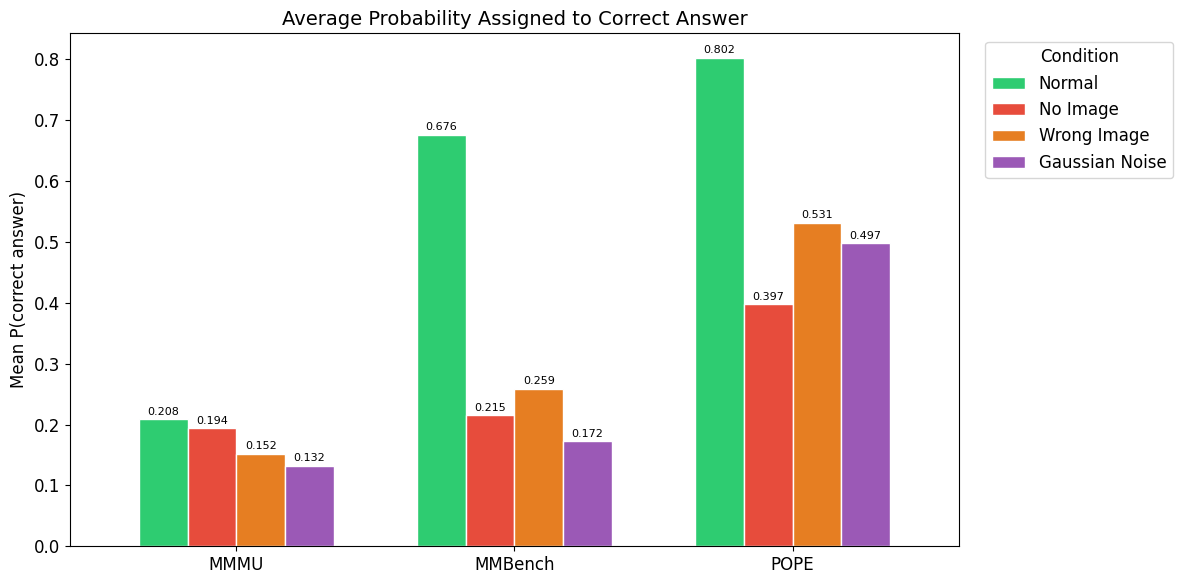

In [6]:
# Average P(ground truth) across conditions
gt_df = df[df['gt_prob'].notna()].copy()

if len(gt_df) > 0:
    gt_by_cond = gt_df.groupby(['benchmark', 'condition'])['gt_prob'].mean().unstack('condition')
    avail_c = [c for c in condition_order if c in gt_by_cond.columns]
    avail_b = [b for b in benchmark_order if b in gt_by_cond.index]
    gt_plot = gt_by_cond.loc[avail_b, avail_c]
    gt_plot.index = [b_label_map.get(b, b) for b in gt_plot.index]
    gt_plot.columns = [c_label_map.get(c, c) for c in gt_plot.columns]
    
    ax = gt_plot.plot(kind='bar', color=colors[:len(avail_c)], width=0.7, edgecolor='white')
    ax.set_ylabel('Mean P(correct answer)')
    ax.set_title('Average Probability Assigned to Correct Answer')
    ax.set_xlabel('')
    ax.legend(title='Condition', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=0)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=8, padding=2)
    
    plt.tight_layout()
    plt.savefig('results/plots/fig5_gt_probability.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No gt_prob data available')

## 6. Noise Optimization — Training Curves

/var/folders/4j/qyrm0vfs33vdsh6fvzsxk6br0000gn/T/ipykernel_61664/1713534785.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


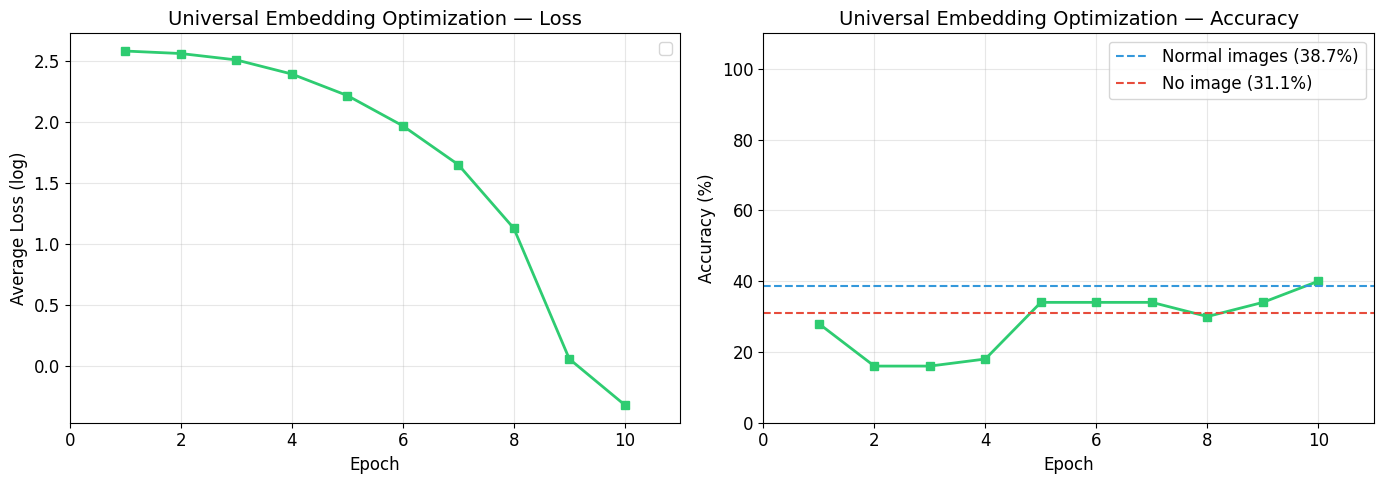

Epochs: 20
Loss: 12.2866 -> 0.7229
Accuracy: 0.0% -> 40.0%
Exponential decay rate: -0.3222 per epoch
Half-life: 2.2 epochs


In [20]:
# Load epoch data
import numpy as np
epoch_file = OPT_DIR / 'mmmu_universal_epochs.jsonl'
epochs = []
if epoch_file.exists():
    with open(epoch_file) as f:
        for line in f:
            if line.strip():
                epochs.append(json.loads(line))

if epochs:
    epoch_df = pd.DataFrame(epochs)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curve (log scale) with exponential trend line

    # Fit exponential decay: log(loss) = a + b*epoch -> loss = exp(a) * exp(b*epoch)
    ax1.plot(epoch_df['epoch'][10:], np.log(epoch_df['avg_loss'][10:]), 's-', color='#2ecc71', linewidth=2, markersize=6)
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Average Loss (log)')
    ax1.set_title('Universal Embedding Optimization — Loss')
    ax1.grid(True, alpha=0.3, which='both')
    ax1.set_xlim(0, epoch_df['epoch'].max() + 1)
    ax1.legend()
    
    # Accuracy curve
    ax2.plot(epoch_df['epoch'][10:], epoch_df['accuracy'][10:], 's-', color='#2ecc71', linewidth=2, markersize=6)
    
    # Add normal MMMU accuracy as reference line
    normal_mmmu = acc.get(('mmmu', 'normal'), None)
    if normal_mmmu is not None:
        ax2.axhline(y=normal_mmmu, color='#3498db', linewidth=1.5, linestyle='--', label=f'Normal images ({normal_mmmu:.1f}%)')
    
    no_img_mmmu = acc.get(('mmmu', 'no_image'), None)
    if no_img_mmmu is not None:
        ax2.axhline(y=no_img_mmmu, color='#e74c3c', linewidth=1.5, linestyle='--', label=f'No image ({no_img_mmmu:.1f}%)')
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Universal Embedding Optimization — Accuracy')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, epoch_df['epoch'].max() + 1)
    ax2.set_ylim(0, max(60, epoch_df['accuracy'].max() + 10))
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('results/plots/fig6_optimization_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Epochs: {len(epoch_df)}")
    print(f"Loss: {epoch_df['avg_loss'].iloc[0]:.4f} -> {epoch_df['avg_loss'].iloc[-1]:.4f}")
    print(f"Accuracy: {epoch_df['accuracy'].iloc[0]:.1f}% -> {epoch_df['accuracy'].iloc[-1]:.1f}%")
    print(f"Exponential decay rate: {coeffs[0]:.4f} per epoch")
    print(f"Half-life: {-np.log(2)/coeffs[0]:.1f} epochs")
else:
    print('No epoch data found')

In [16]:
print(epoch_df['avg_loss'][10:])

10    13.2609
11    12.9926
12    12.3292
13    10.9790
14     9.2009
15     7.1728
16     5.2121
17     3.0890
18     1.0554
19     0.7229
Name: avg_loss, dtype: float64


## 7. Per-Question Loss Distribution (Universal Embeddings)

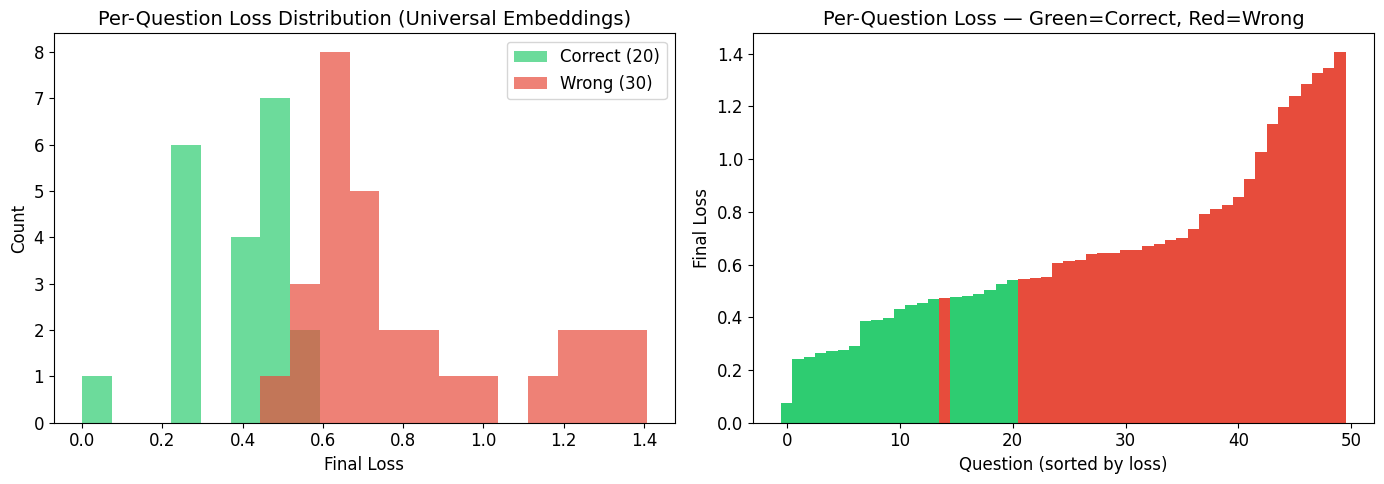

Correct: 20/50 (40.0%)
Mean loss (correct): 0.3832
Mean loss (wrong):   0.8285


In [8]:
# Load per-question results from universal optimization
emb_file = OPT_DIR / 'mmmu_universal_embeddings.jsonl'
emb_results = []
if emb_file.exists():
    with open(emb_file) as f:
        for line in f:
            if line.strip():
                emb_results.append(json.loads(line))

if emb_results:
    emb_df = pd.DataFrame(emb_results)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss histogram: correct vs incorrect
    correct_losses = emb_df[emb_df['correct']]['final_loss']
    wrong_losses = emb_df[~emb_df['correct']]['final_loss']
    
    bins = np.linspace(0, emb_df['final_loss'].max(), 20)
    ax1.hist(correct_losses, bins=bins, alpha=0.7, label=f'Correct ({len(correct_losses)})', color='#2ecc71')
    ax1.hist(wrong_losses, bins=bins, alpha=0.7, label=f'Wrong ({len(wrong_losses)})', color='#e74c3c')
    ax1.set_xlabel('Final Loss')
    ax1.set_ylabel('Count')
    ax1.set_title('Per-Question Loss Distribution (Universal Embeddings)')
    ax1.legend()
    
    # Sorted loss bar chart
    emb_sorted = emb_df.sort_values('final_loss')
    bar_colors = ['#2ecc71' if c else '#e74c3c' for c in emb_sorted['correct']]
    ax2.bar(range(len(emb_sorted)), emb_sorted['final_loss'], color=bar_colors, width=1.0)
    ax2.set_xlabel('Question (sorted by loss)')
    ax2.set_ylabel('Final Loss')
    ax2.set_title('Per-Question Loss — Green=Correct, Red=Wrong')
    
    plt.tight_layout()
    plt.savefig('results/plots/fig7_per_question_loss.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'Correct: {emb_df["correct"].sum()}/{len(emb_df)} ({emb_df["correct"].mean()*100:.1f}%)')
    print(f'Mean loss (correct): {correct_losses.mean():.4f}')
    print(f'Mean loss (wrong):   {wrong_losses.mean():.4f}')
else:
    print('No embedding results found')

## 8. Summary Comparison — All Conditions + Optimized Noise

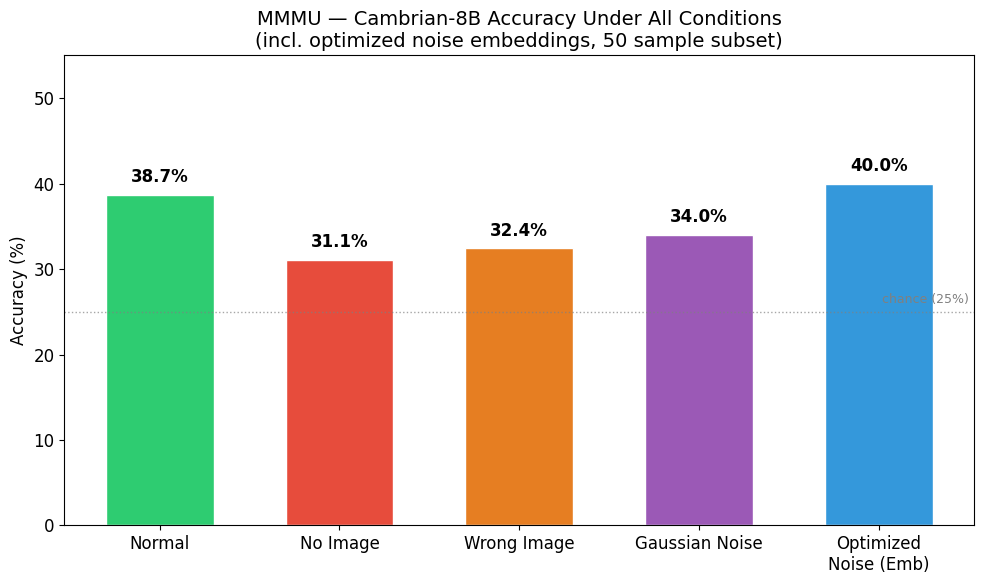

In [9]:
# Build comparison for MMMU (the benchmark we have optimization data for)
mmmu_acc = {}
for cond in condition_order:
    a = acc.get(('mmmu', cond), None)
    if a is not None:
        mmmu_acc[c_label_map.get(cond, cond)] = a

# Add optimized noise result
if emb_results:
    opt_acc = sum(1 for r in emb_results if r['correct']) / len(emb_results) * 100
    mmmu_acc['Optimized\nNoise (Emb)'] = opt_acc

if mmmu_acc:
    fig, ax = plt.subplots(figsize=(10, 6))
    labels = list(mmmu_acc.keys())
    values = list(mmmu_acc.values())
    bar_colors = ['#2ecc71', '#e74c3c', '#e67e22', '#9b59b6', '#3498db']
    
    bars = ax.bar(labels, values, color=bar_colors[:len(labels)], edgecolor='white', width=0.6)
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('MMMU — Cambrian-8B Accuracy Under All Conditions\n(incl. optimized noise embeddings, 50 sample subset)')
    ax.set_ylim(0, max(values) + 15)
    
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Chance level for 4-choice MCQ
    ax.axhline(y=25, color='gray', linewidth=1, linestyle=':', alpha=0.7)
    ax.text(len(labels)-0.5, 26, 'chance (25%)', color='gray', fontsize=9, ha='right')
    
    plt.tight_layout()
    plt.savefig('results/plots/fig8_mmmu_all_conditions.png', dpi=150, bbox_inches='tight')
    plt.show()

## 9. Approximate Noise Image from Optimized Embeddings

The embeddings are encoder **output** tensors (not pixel values), so we can't directly convert them to an image. But we can visualize the structure of what the model "sees".

Encoder output shapes:
  SigLIP: [1, 576, 1152]
  CLIP: [1, 576, 1024]
  DINOv2: [1, 576, 1536]
  ConvNeXt: [1, 9216, 5760]


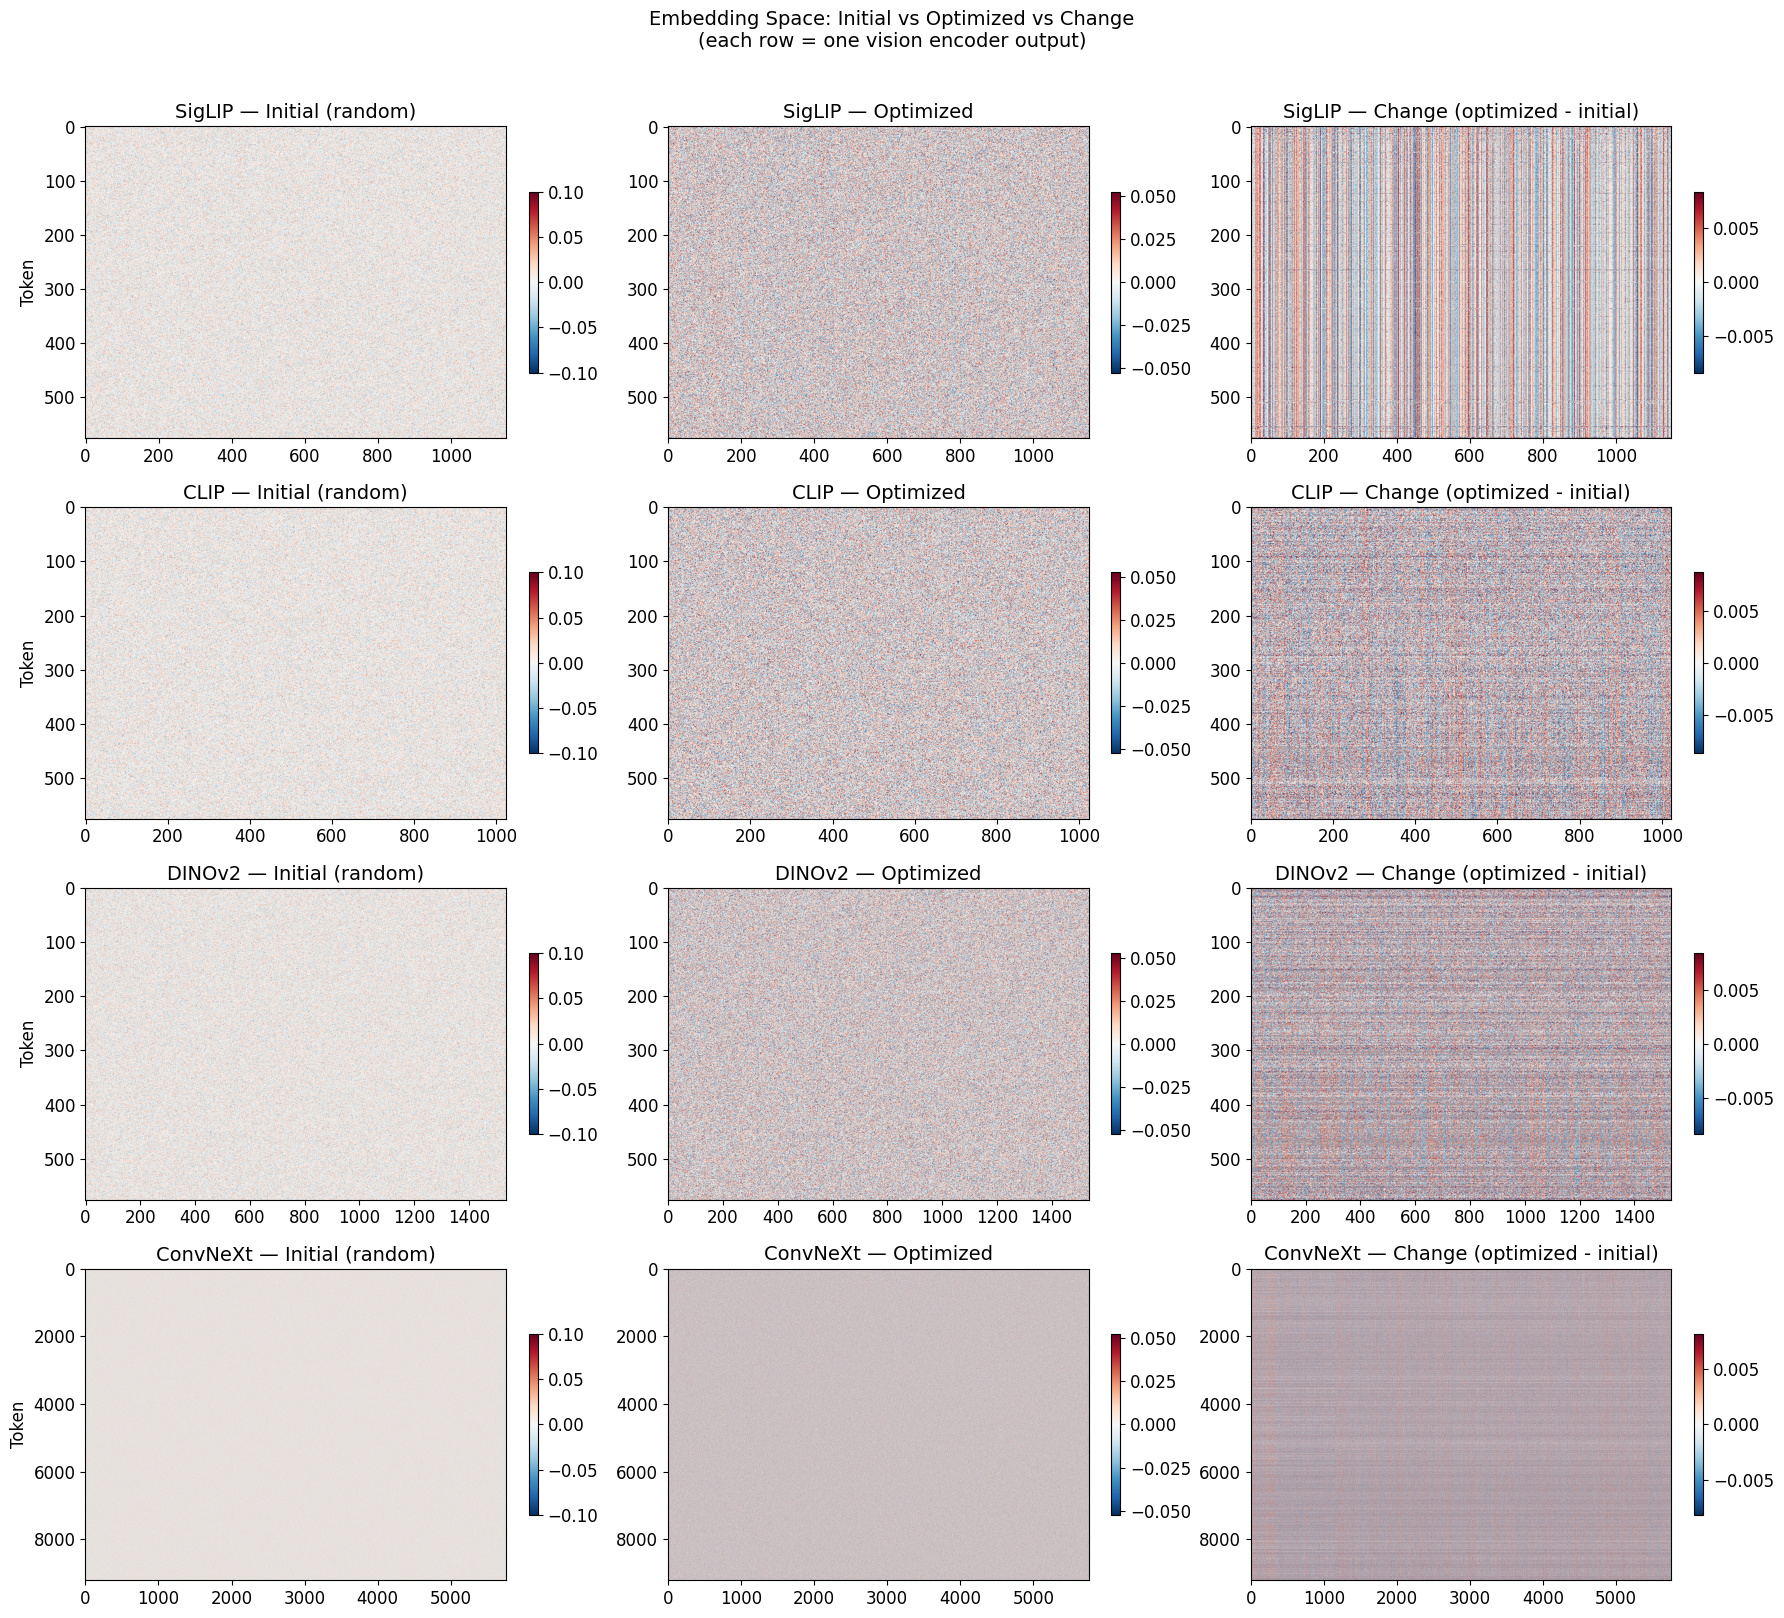

In [10]:
import torch

tensors_dir = OPT_DIR / 'tensors'

# Load initial (random) and final (optimized) embeddings
initial_path = tensors_dir / 'mmmu_universal_initial.pt'
final_path = tensors_dir / 'mmmu_universal.pt'

encoder_names = ['SigLIP', 'CLIP', 'DINOv2', 'ConvNeXt']

if initial_path.exists() and final_path.exists():
    initial_tensors = torch.load(initial_path, map_location='cpu', weights_only=True)
    final_tensors = torch.load(final_path, map_location='cpu', weights_only=True)
    
    print('Encoder output shapes:')
    for i, (name, t) in enumerate(zip(encoder_names, final_tensors)):
        print(f'  {name}: {list(t.shape)}')
    
    # Visualize each encoder's embedding as a 2D heatmap
    # Shape is [1, num_tokens, hidden_dim] — squeeze batch and show tokens x hidden_dim
    fig, axes = plt.subplots(4, 3, figsize=(18, 16))
    
    for i, name in enumerate(encoder_names):
        init_t = initial_tensors[i].squeeze(0).float().numpy()  # [tokens, hidden]
        final_t = final_tensors[i].squeeze(0).float().numpy()
        diff_t = final_t - init_t
        
        # Initial
        im0 = axes[i, 0].imshow(init_t, aspect='auto', cmap='RdBu_r', vmin=-0.1, vmax=0.1)
        axes[i, 0].set_title(f'{name} — Initial (random)')
        axes[i, 0].set_ylabel('Token')
        plt.colorbar(im0, ax=axes[i, 0], fraction=0.02)
        
        # Final (optimized)
        vmax = np.percentile(np.abs(final_t), 99)
        im1 = axes[i, 1].imshow(final_t, aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
        axes[i, 1].set_title(f'{name} — Optimized')
        plt.colorbar(im1, ax=axes[i, 1], fraction=0.02)
        
        # Difference (what optimization learned)
        vmax_d = np.percentile(np.abs(diff_t), 99)
        im2 = axes[i, 2].imshow(diff_t, aspect='auto', cmap='RdBu_r', vmin=-vmax_d, vmax=vmax_d)
        axes[i, 2].set_title(f'{name} — Change (optimized - initial)')
        plt.colorbar(im2, ax=axes[i, 2], fraction=0.02)
    
    plt.suptitle('Embedding Space: Initial vs Optimized vs Change\n(each row = one vision encoder output)', fontsize=14, y=1.01)
    plt.tight_layout()
    plt.savefig('results/plots/fig9_embedding_heatmaps.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f'Tensor files not found at {tensors_dir}')

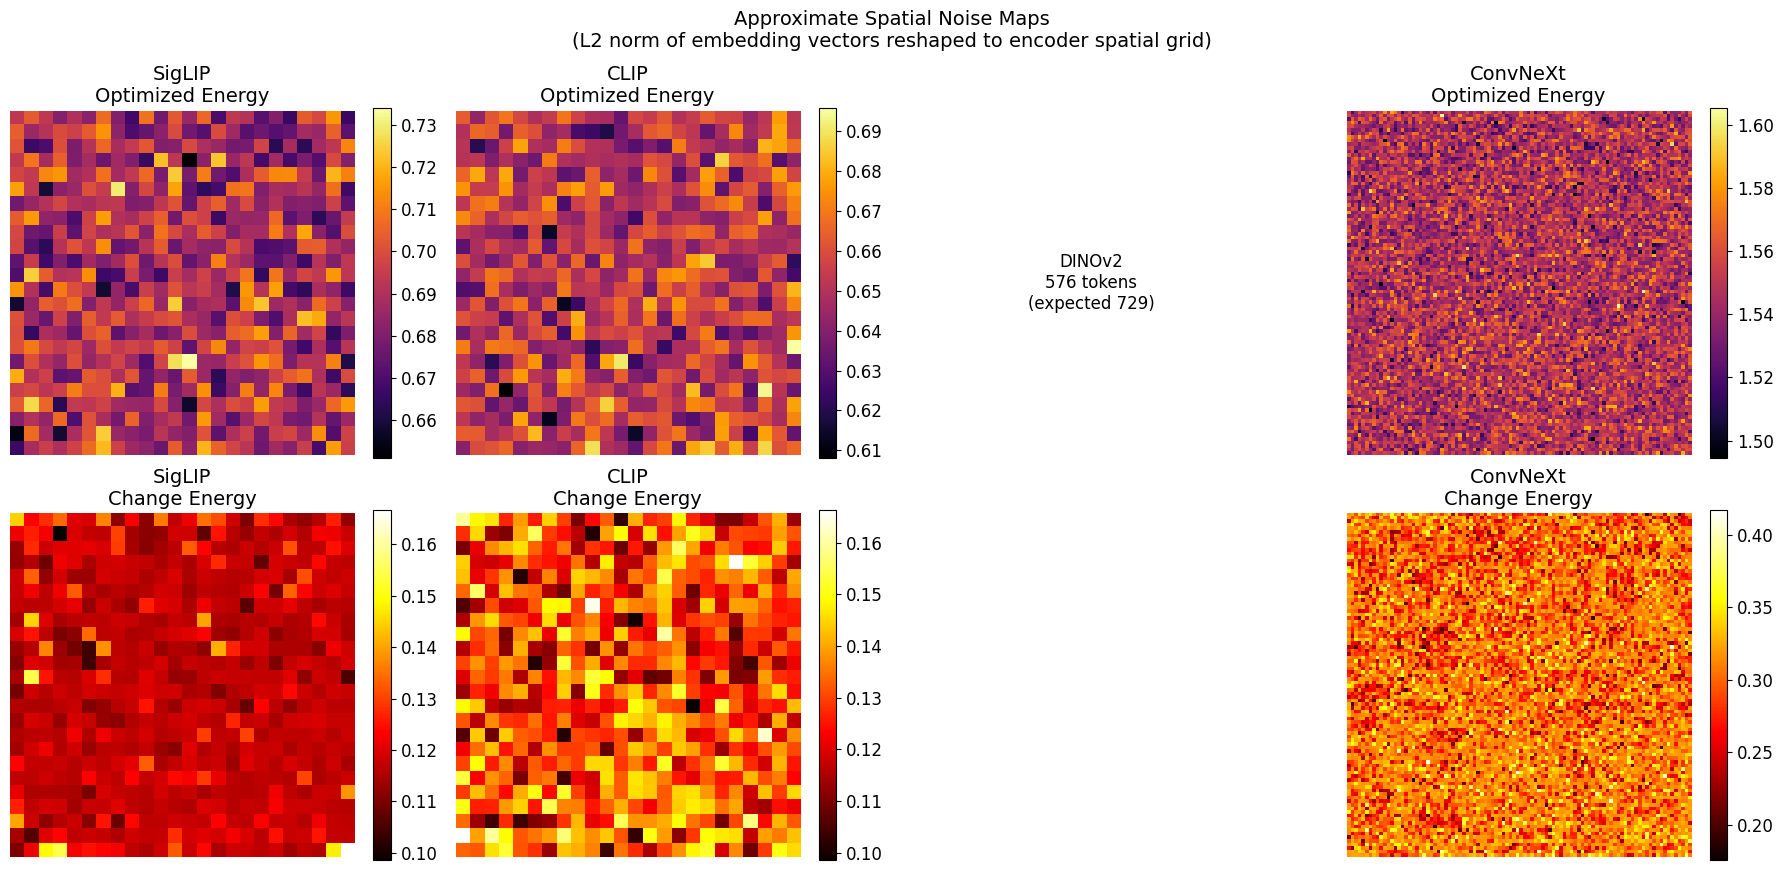

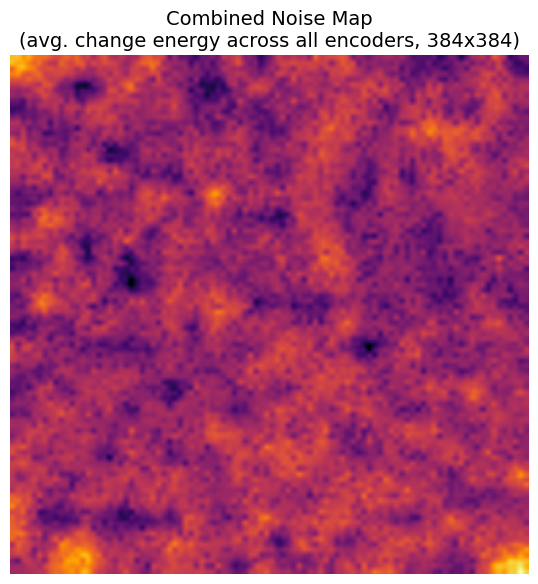

In [11]:
# Approximate noise image: project embeddings back to a 2D spatial grid
# SigLIP outputs 576 tokens from a 24x24 spatial grid (384/16 patches)
# We can reshape tokens back to spatial layout and average across hidden dims

if initial_path.exists() and final_path.exists():
    spatial_grids = {
        'SigLIP': (24, 24),     # 576 tokens = 24x24
        'CLIP': (24, 24),       # 576 tokens = 24x24
        'DINOv2': (27, 27),     # 729 tokens = 27x27
        'ConvNeXt': (96, 96),   # 9216 tokens = 96x96
    }
    
    fig, axes = plt.subplots(2, 4, figsize=(18, 9))
    
    for i, name in enumerate(encoder_names):
        final_t = final_tensors[i].squeeze(0).float()  # [tokens, hidden]
        init_t = initial_tensors[i].squeeze(0).float()
        diff_t = final_t - init_t
        
        h, w = spatial_grids[name]
        n_tokens = final_t.shape[0]
        
        if n_tokens >= h * w:
            # Reshape to spatial grid, take L2 norm across hidden dim
            final_spatial = final_t[:h*w].reshape(h, w, -1).numpy()
            diff_spatial = diff_t[:h*w].reshape(h, w, -1).numpy()
            
            # Energy map: L2 norm per spatial position
            energy_final = np.linalg.norm(final_spatial, axis=-1)
            energy_diff = np.linalg.norm(diff_spatial, axis=-1)
            
            im0 = axes[0, i].imshow(energy_final, cmap='inferno')
            axes[0, i].set_title(f'{name}\nOptimized Energy')
            axes[0, i].axis('off')
            plt.colorbar(im0, ax=axes[0, i], fraction=0.046)
            
            im1 = axes[1, i].imshow(energy_diff, cmap='hot')
            axes[1, i].set_title(f'{name}\nChange Energy')
            axes[1, i].axis('off')
            plt.colorbar(im1, ax=axes[1, i], fraction=0.046)
        else:
            axes[0, i].text(0.5, 0.5, f'{name}\n{n_tokens} tokens\n(expected {h*w})',
                          ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')
            axes[1, i].axis('off')
    
    plt.suptitle('Approximate Spatial Noise Maps\n(L2 norm of embedding vectors reshaped to encoder spatial grid)', fontsize=14)
    plt.tight_layout()
    plt.savefig('results/plots/fig10_approximate_noise_image.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Also create a combined "pseudo-image" by upscaling all grids to 384x384 and averaging
    from PIL import Image
    
    combined = np.zeros((384, 384))
    count = 0
    for i, name in enumerate(encoder_names):
        diff_t = (final_tensors[i].squeeze(0).float() - initial_tensors[i].squeeze(0).float())
        h, w = spatial_grids[name]
        n_tokens = diff_t.shape[0]
        if n_tokens >= h * w:
            diff_spatial = diff_t[:h*w].reshape(h, w, -1).numpy()
            energy = np.linalg.norm(diff_spatial, axis=-1)
            # Normalize to [0, 1]
            energy = (energy - energy.min()) / (energy.max() - energy.min() + 1e-8)
            # Upscale to 384x384
            img = Image.fromarray((energy * 255).astype(np.uint8))
            img = img.resize((384, 384), Image.BILINEAR)
            combined += np.array(img).astype(float) / 255
            count += 1
    
    if count > 0:
        combined /= count
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(combined, cmap='inferno')
        ax.set_title('Combined Noise Map\n(avg. change energy across all encoders, 384x384)')
        ax.axis('off')
        plt.tight_layout()
        plt.savefig('results/plots/fig11_combined_noise_map.png', dpi=150, bbox_inches='tight')
        plt.show()

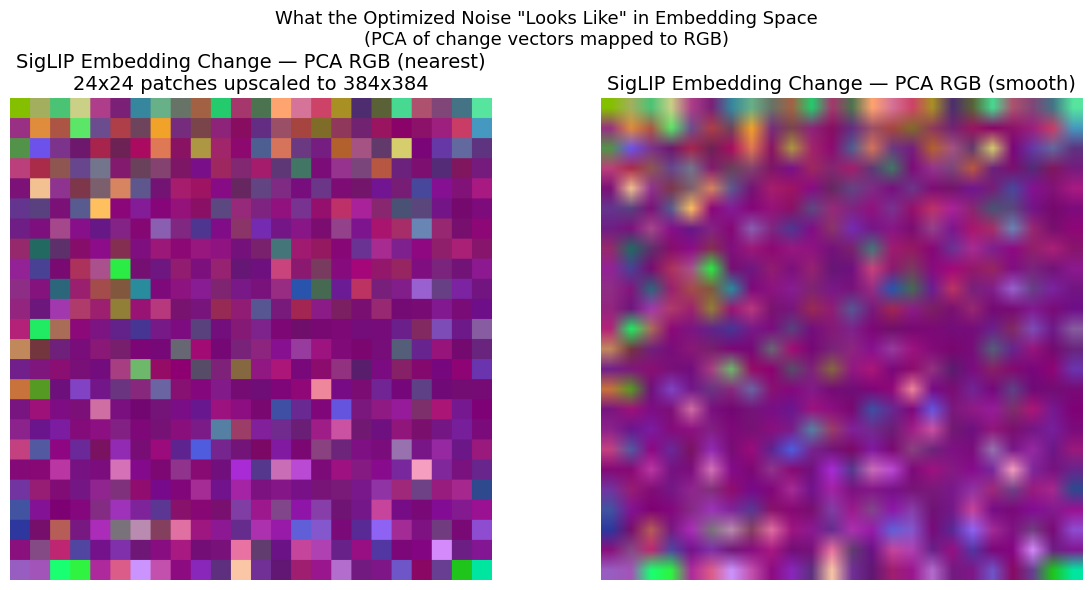

PCA explained variance: [0.323 0.084 0.041]
Total variance explained: 44.8%


In [12]:
# RGB pseudo-image: use first 3 principal components of the change vectors as RGB channels
from sklearn.decomposition import PCA

if initial_path.exists() and final_path.exists():
    # Use SigLIP (24x24, 576 tokens) for the clearest spatial structure
    diff_t = (final_tensors[0].squeeze(0).float() - initial_tensors[0].squeeze(0).float()).numpy()
    
    # PCA to 3 components
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(diff_t)  # [576, 3]
    
    # Reshape to 24x24x3
    h, w = 24, 24
    rgb = pca_result[:h*w].reshape(h, w, 3)
    
    # Normalize each channel to [0, 1]
    for c in range(3):
        ch = rgb[:, :, c]
        rgb[:, :, c] = (ch - ch.min()) / (ch.max() - ch.min() + 1e-8)
    
    # Upscale
    from PIL import Image
    rgb_img = Image.fromarray((rgb * 255).astype(np.uint8))
    rgb_384 = rgb_img.resize((384, 384), Image.NEAREST)  # Nearest for blocky patch look
    rgb_384_smooth = rgb_img.resize((384, 384), Image.BILINEAR)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(rgb_384)
    ax1.set_title('SigLIP Embedding Change — PCA RGB (nearest)\n24x24 patches upscaled to 384x384')
    ax1.axis('off')
    
    ax2.imshow(rgb_384_smooth)
    ax2.set_title('SigLIP Embedding Change — PCA RGB (smooth)')
    ax2.axis('off')
    
    plt.suptitle('What the Optimized Noise "Looks Like" in Embedding Space\n(PCA of change vectors mapped to RGB)', fontsize=13)
    plt.tight_layout()
    plt.savefig('results/plots/fig12_pca_noise_rgb.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'PCA explained variance: {pca.explained_variance_ratio_.round(3)}')
    print(f'Total variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%')

## 10. Summary Table

In [13]:
# Final summary table
summary_rows = []
for bench in avail_benchmarks:
    b_label = b_label_map.get(bench, bench)
    row = {'Benchmark': b_label}
    for cond in avail_conditions:
        c_label = c_label_map.get(cond, cond)
        a = acc.get((bench, cond), None)
        row[c_label] = f'{a:.1f}%' if a is not None else '-'
    
    # Add sample count
    n = len(df[(df['benchmark'] == bench) & (df['condition'] == 'normal')])
    row['N'] = n
    
    # Image reliance
    normal_a = acc.get((bench, 'normal'), 0)
    no_img_a = acc.get((bench, 'no_image'), 0)
    row['Image Reliance'] = f'{(normal_a - no_img_a) / normal_a * 100:.1f}%' if normal_a > 0 else '-'
    
    summary_rows.append(row)

summary_table = pd.DataFrame(summary_rows).set_index('Benchmark')
print('=== Final Summary ===')
print()
print(summary_table.to_string())
print()

# Optimization summary
summary_path = OPT_DIR / 'mmmu_universal_summary.json'
if summary_path.exists():
    with open(summary_path) as f:
        opt_summary = json.load(f)
    print('=== Noise Optimization (MMMU, Universal Embeddings) ===')
    print(f'  Samples: {opt_summary["num_samples"]}')
    print(f'  Epochs: {opt_summary["num_epochs"]}')
    print(f'  Loss: {opt_summary["initial_avg_loss"]:.4f} -> {opt_summary["final_avg_loss"]:.4f}')
    print(f'  Accuracy: {opt_summary["accuracy"]:.1f}%')
    print(f'  vs Normal images: {acc.get(("mmmu", "normal"), 0):.1f}%')
    print(f'  vs No image: {acc.get(("mmmu", "no_image"), 0):.1f}%')
    print(f'  Time: {opt_summary["optimization_time_s"]/60:.0f} minutes')

=== Final Summary ===

          Normal No Image Wrong Image Gaussian Noise     N Image Reliance
Benchmark                                                                
MMMU       38.7%    31.1%       32.4%          34.0%   900          19.5%
MMBench    80.8%    33.5%       35.3%          33.7%  4329          58.5%
POPE       84.6%    50.0%       53.6%          50.0%  9000          40.9%
TextVQA    68.2%     7.2%        3.8%           4.0%  5000          89.5%

=== Noise Optimization (MMMU, Universal Embeddings) ===
  Samples: 50
  Epochs: 10
  Loss: 13.2609 -> 0.7229
  Accuracy: 40.0%
  vs Normal images: 38.7%
  vs No image: 31.1%
  Time: 123 minutes
